# Importation des bibliothèques 

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import warnings
import re

# Suppression des avertissements
warnings.filterwarnings('ignore')


# Importation des données

In [45]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

print(f"Taille du jeu de données d'entraînement: {df_train.shape}")
print(f"Taille du jeu de données de test: {df_test.shape}")


Taille du jeu de données d'entraînement: (891, 12)
Taille du jeu de données de test: (418, 11)


In [46]:
print(df_train.head())
print(df_test.head())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

# Gestion des Valeurs Manquantes 

In [47]:
imputer_median = SimpleImputer(strategy='median')
imputer_mode = SimpleImputer(strategy='most_frequent')

df_train['Age'] = imputer_median.fit_transform(df_train[['Age']])
df_test['Age'] = imputer_median.transform(df_test[['Age']])

df_train['Embarked'] = imputer_mode.fit_transform(df_train[['Embarked']])
df_test['Embarked'] = imputer_mode.transform(df_test[['Embarked']])

df_train['Fare'] = imputer_median.fit_transform(df_train[['Fare']])
df_test['Fare'] = imputer_median.transform(df_test[['Fare']])


# Ingénierie des Caractéristiques: Extraction des Titres depuis le Nom

In [48]:
def extract_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for df in [df_train, df_test]:
    df['Title'] = df['Name'].apply(extract_title)

# Regrouper les titres rares
title_mapping = {
    "Mr": "Mr",
    "Miss": "Miss",
    "Mrs": "Mrs",
    "Master": "Master",
    "Dr": "Rare",
    "Rev": "Rare",
    "Col": "Rare",
    "Major": "Rare",
    "Mlle": "Miss",
    "Countess": "Rare",
    "Ms": "Miss",
    "Lady": "Rare",
    "Jonkheer": "Rare",
    "Don": "Rare",
    "Dona": "Rare",
    "Mme": "Mrs",
    "Capt": "Rare",
    "Sir": "Rare"
}

for df in [df_train, df_test]:
    df['Title'] = df['Title'].map(title_mapping)
    df['Title'] = df['Title'].fillna('Rare')

# Encodage des Titres
label_encoders = {}
label_encoders['Title'] = LabelEncoder()
df_train['Title'] = label_encoders['Title'].fit_transform(df_train['Title'])
df_test['Title'] = label_encoders['Title'].transform(df_test['Title'])


# Ingénierie des Caractéristiques: Création de la Taille de la Famille et IsAlone

In [49]:
for df in [df_train, df_test]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = 1  # 1 signifie seul
    df.loc[df['FamilySize'] > 1, 'IsAlone'] = 0


# Ingénierie des Caractéristiques: Catégorisation de l'Âge

In [50]:
for df in [df_train, df_test]:
    df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 20, 40, 60, 80], labels=[0, 1, 2, 3, 4])
    df['AgeBin'] = df['AgeBin'].astype(int)


# Encodage One-Hot des Variables Catégorielles

In [51]:
categorical_columns_extended = ['Sex', 'Embarked', 'Title']
df_train = pd.get_dummies(df_train, columns=categorical_columns_extended, drop_first=True)
df_test = pd.get_dummies(df_test, columns=categorical_columns_extended, drop_first=True)

# Aligner les colonnes des deux jeux de données
df_train, df_test = df_train.align(df_test, join='left', axis=1, fill_value=0)


# Suppression des Colonnes Après Ingénierie des Caractéristiques

In [52]:
columns_to_drop_extended = ['SibSp', 'Parch', 'Age', 'AgeBin', 'Name', 'Ticket', 'Cabin']
df_train.drop(columns_to_drop_extended, axis=1, inplace=True)
df_test.drop(columns_to_drop_extended, axis=1, inplace=True)


# Séparation des Features et de la Target

In [53]:
X = df_train.drop('Survived', axis=1)
Y = df_train['Survived']


# Division des Données en Ensembles d'Entraînement et de Validation

In [54]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)


# Mise à l'Échelle des Données (Optionnel pour les modèles basés sur les arbres)

In [55]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
df_test_scaled = scaler.transform(df_test.drop(['Survived'], axis=1, errors='ignore'))  # Ajuster si nécessaire


# Définition de la Grille de Paramètres pour GridSearchCV

In [56]:
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}


# Entraînement du Modèle Gradient Boosting avec GridSearchCV

In [57]:
gradient_boosting = GradientBoostingClassifier(random_state=42)
grid_search_gb = GridSearchCV(
    estimator=gradient_boosting,
    param_grid=param_grid_gb,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search_gb.fit(X_train_scaled, Y_train)
best_gradient_boosting = grid_search_gb.best_estimator_


Fitting 5 folds for each of 16 candidates, totalling 80 fits


# Entraînement avec Random Forest et XGBoost

In [58]:
# Random Forest
param_grid_rf = {
    'n_estimators': [200, 500],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_forest = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(
    estimator=random_forest,
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, Y_train)
best_rf = grid_search_rf.best_estimator_

# XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search_xgb.fit(X_train, Y_train)
best_xgb = grid_search_xgb.best_estimator_


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits


# Création d'un Ensemble de Modèles

In [59]:
ensemble = VotingClassifier(
    estimators=[
        ('gb', best_gradient_boosting),
        ('rf', best_rf),
        ('xgb', best_xgb)
    ],
    voting='soft'  # 'soft' pour utiliser les probabilités moyennes
)

ensemble.fit(X_train_scaled, Y_train)


VotingClassifier(estimators=[('gb',
                              GradientBoostingClassifier(min_samples_split=5,
                                                         random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=8,
                                                     min_samples_split=10,
                                                     n_estimators=500,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0, device=None,
                                            early_stop...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

# Évaluation des Modèles

In [60]:
# Gradient Boosting
Y_val_pred_gb = best_gradient_boosting.predict(X_val_scaled)
f1_score_val_gb = metrics.f1_score(Y_val, Y_val_pred_gb, average='macro')
print(f'Gradient Boosting Validation Macro F1 Score: {f1_score_val_gb}')

# Random Forest
Y_val_pred_rf = best_rf.predict(X_val)
f1_score_val_rf = metrics.f1_score(Y_val, Y_val_pred_rf, average='macro')
print(f'Random Forest Validation Macro F1 Score: {f1_score_val_rf}')

# XGBoost
Y_val_pred_xgb = best_xgb.predict(X_val)
f1_score_val_xgb = metrics.f1_score(Y_val, Y_val_pred_xgb, average='macro')
print(f'XGBoost Validation Macro F1 Score: {f1_score_val_xgb}')

# Ensemble
Y_val_pred_ensemble = ensemble.predict(X_val_scaled)
f1_score_val_ensemble = metrics.f1_score(Y_val, Y_val_pred_ensemble, average='macro')
print(f'Ensemble Validation Macro F1 Score: {f1_score_val_ensemble}')


Gradient Boosting Validation Macro F1 Score: 0.8215949940087872
Random Forest Validation Macro F1 Score: 0.8013873243611787
XGBoost Validation Macro F1 Score: 0.8172763384122843
Ensemble Validation Macro F1 Score: 0.8064696779898313


# Analyse de l'Importance des Caractéristiques

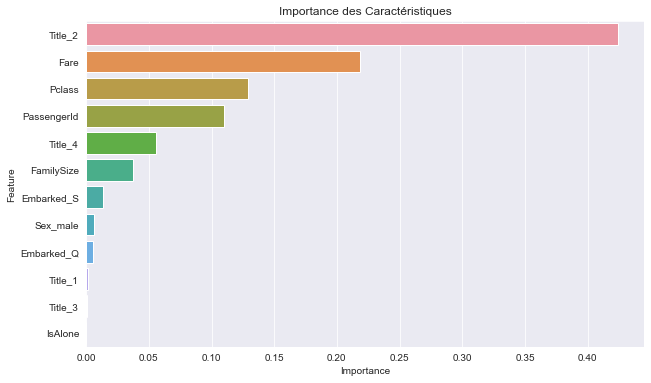

In [61]:
importances = best_gradient_boosting.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importance des Caractéristiques')
plt.show()


# Validation Croisée Améliorée

In [62]:
scores = cross_val_score(ensemble, X_train_scaled, Y_train, cv=5, scoring='f1_macro')
print(f'Cross-Validation Macro F1 Scores: {scores}')
print(f'Mean CV Macro F1 Score: {scores.mean()}')


Cross-Validation Macro F1 Scores: [0.78729438 0.84217172 0.75016656 0.77364001 0.82995309]
Mean CV Macro F1 Score: 0.796645151501122


# Prédiction sur le Jeu de Test et Création du Fichier de Soumission

In [63]:
ensemble.fit(X, Y)
test_predictions = ensemble.predict(df_test_scaled)

submission = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Survived': test_predictions
})

submission.to_csv('./data/submission.csv', index=False)
print("Fichier de soumission créé avec succès !")


Fichier de soumission créé avec succès !
